# Literary Analysis: Comparing Nonfiction and Fiction through Topic Modeling and Sentiment Analysis 

### ADS 509 Final Project
##### Team 3: Claire Bentzen, Tara Dehdari, Logan Van Dine

##### Introduction

In this project, we analyze the thematic and stylistic differences between fiction and nonfiction by examining texts that address significant social issues, particularly related to gender and individual rights. We also hope to train numerous classification models to properly recognize select verbiage as either fiction or nonfiction text. We focus on four key fiction books—"Pride and Prejudice" by Jane Austen, "The Awakening" by Kate Chopin, "North and South" by Elizabeth Gaskell, and "Wuthering Heights" by Emily Brontë—and four nonfiction works, including "A Vindication of the Rights of Woman" by Mary Wollstonecraft, "Enfranchisement of Women" by Harriet Hardy Taylor Mill, "On Liberty" by John Stuart Mill, and "The Subjection of Women" by John Stuart Mill. By applying text mining techniques such as data cleaning, tokenization, sentiment analysis, and topic modeling, we explore how fiction and nonfiction differ in their approaches to discussing similar themes.

Our analysis will involve data cleaning, tokenization, and the application of descriptive statistics, classfication, topic modeling, and sentiment analysis. By comparing these works, we aim to uncover the unique ways in which each genre communicates similar ideas, providing insights into the broader distinctions between fiction and nonfiction writing.

### Imports

In [3]:
import requests
import os
import re
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimmod
import gensim

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from bs4 import BeautifulSoup  
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from string import punctuation
from collections import Counter, defaultdict
from wordcloud import WordCloud
from gensim import corpora
from tabulate import tabulate

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")

### Scraping

We scraped full-text versions of both fiction and nonfiction books from Project Gutenberg. Each text is processed, saved as a .txt file, and previewed to verify successful scraping. This step ensures we have clean and accessible data for further analysis.

In [4]:
# Define the URLs for the books
## fiction
url_pride_prej = 'https://www.gutenberg.org/cache/epub/1342/pg1342-images.html'
url_awakening = 'https://www.gutenberg.org/cache/epub/160/pg160-images.html'
url_north_south = 'https://www.gutenberg.org/cache/epub/4276/pg4276-images.html'
url_wuthering_heights = 'https://www.gutenberg.org/cache/epub/768/pg768-images.html'
## nonfiction
url_vin_of_women = 'https://www.gutenberg.org/cache/epub/3420/pg3420-images.html'
url_enfranchisement = 'https://www.gutenberg.org/cache/epub/73404/pg73404-images.html'
url_on_liberty = 'https://www.gutenberg.org/cache/epub/34901/pg34901-images.html'
url_subjection_women = 'https://www.gutenberg.org/cache/epub/27083/pg27083-images.html'

# Define the directory to save the files
data_dir = './data'

# Ensure the directory exists
os.makedirs(data_dir, exist_ok=True)

# Function to scrape and save books
def scrape_and_save_book(url, file_name):
    # Send a GET request to the URL
    response = requests.get(url)
    response.raise_for_status()  # Check that the request was successful
    
    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Extract all text from <p> tags
    paragraphs = soup.find_all(['p', 'h1', 'h2', 'h3'])
    book_text = '\n'.join([para.get_text() for para in paragraphs if para.get_text().strip()])

    
    # Save the extracted text to a file
    file_path = os.path.join(data_dir, file_name)
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(book_text)
    
    print(f"Text from '{file_name}' scraped and saved.")
    
    # Check if the file is saved and contains content
    if os.path.exists(file_path):
        print(f"File '{file_path}' has been created successfully.")
        # Check the first few lines of the file
        with open(file_path, 'r', encoding='utf-8') as file:
            preview = file.read(100)  # Read the first 100 characters
            print("File content preview:\n")
            print(preview)
    else:
        print(f"Failed to create the file '{file_path}'.")

# List of Fiction book tuples
fiction_books = [
    (url_pride_prej, 'pride_and_prejudice.txt'),
    (url_awakening, 'the_awakening.txt'),
    (url_north_south, 'north_and_south.txt'),
    (url_wuthering_heights, 'wuthering_heights.txt')
]

# Loop over the list and scrape/save each book
for url, filename in fiction_books:
    scrape_and_save_book(url, filename)

# List of Nonfiction book tuples
nonfiction_books = [
    (url_vin_of_women, 'vindication_of_rights_of_woman.txt'),
    (url_enfranchisement, 'the_enfranchisement_of_women.txt'),
    (url_on_liberty, 'on_liberty.txt'),
    (url_subjection_women, 'the_subjection_of_women.txt')
]

# Loop over the list and scrape/save each book
for url, filename in nonfiction_books:
    scrape_and_save_book(url, filename)

Text from 'pride_and_prejudice.txt' scraped and saved.
File './data\pride_and_prejudice.txt' has been created successfully.
File content preview:

The Project Gutenberg eBook of Pride and Prejudice
Title: Pride and Prejudice
Author: Jane Austen
Re
Text from 'the_awakening.txt' scraped and saved.
File './data\the_awakening.txt' has been created successfully.
File content preview:

The Project Gutenberg eBook of The Awakening, and Selected Short Stories
Title: The Awakening, and S
Text from 'north_and_south.txt' scraped and saved.
File './data\north_and_south.txt' has been created successfully.
File content preview:

The Project Gutenberg eBook of North and South
Title: North and South
Author: Elizabeth Cleghorn Gas
Text from 'wuthering_heights.txt' scraped and saved.
File './data\wuthering_heights.txt' has been created successfully.
File content preview:

The Project Gutenberg eBook of Wuthering Heights
Title: Wuthering Heights
Author: Emily Brontë
Relea
Text from 'vindication_of_rights

### Data Cleaning and Tokenization

In this step, the raw text files are converted into a structured DataFrame, which includes metadata such as title, author, release date, and genre. The text is then cleaned and tokenized, removing punctuation, converting to lowercase, and excluding stopwords, resulting in a standardized format for analysis.

In [5]:
# Initialize empty dataframe
books = pd.DataFrame(columns=['Title', 'Author', 'Release_Date', 'Updated_Date', 'Language', 'Credits', 'Text', 'Genre'])

# Function to convert text to DataFrame
def convert_to_df(file_name, genre):
    # Establish file path
    file_path = os.path.join(data_dir, file_name)
    
    # Open contents of file
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            
            # Extract relevant sections with error handling for missing fields
            title = re.search(r'Title:\s*(.*)', content)
            title = title.group(1) if title else 'Unknown'
            
            author = re.search(r'Author:\s*(.*)', content)
            author = author.group(1) if author else 'Unknown'
            
            release_date = re.search(r'Release date:\s*(.*)\[eBook', content)
            release_date = release_date.group(1).strip() if release_date else 'Unknown'
            
            updated_date = re.search(r'Most recently updated:\s*(.*)', content)
            updated_date = updated_date.group(1) if updated_date else 'Not available'
            
            language = re.search(r'Language:\s*(.*)', content)
            language = language.group(1) if language else 'Unknown'
            
            credits = re.search(r'Credits:\s*(.*)', content)
            credits = credits.group(1) if credits else 'Not available'
            
            # Extract book text
            match = re.search(r'Credits:.*?\n(.*)', content, re.DOTALL)
            book_text = match.group(1).strip() if match else 'No text available'
            
            # Dictionary for book information
            book_info = {
                'Title': title,
                'Author': author,
                'Release_Date': release_date,
                'Updated_Date': updated_date,
                'Language': language,
                'Credits': credits,
                'Text': book_text,
                'Genre': genre  
            }
            
            # Add data to books DataFrame
            books.loc[len(books)] = book_info
            
    else:
        print(f"The file '{file_name}' does not exist.")

##### Call on Dataframe Function with both texts

In [6]:
# Create list/loop to call on dataframe function
# Combined list of  tuples for both Fiction and Nonfiction
books_list = [
    ('pride_and_prejudice.txt', 'Fiction'),
    ('the_awakening.txt', 'Fiction'),
    ('north_and_south.txt', 'Fiction'),
    ('wuthering_heights.txt', 'Fiction'),
    ('vindication_of_rights_of_woman.txt', 'Nonfiction'),
    ('the_enfranchisement_of_women.txt', 'Nonfiction'),
    ('on_liberty.txt', 'Nonfiction'),
    ('the_subjection_of_women.txt', 'Nonfiction')
]

# Loop over the combined list and convert to DataFrame
for filename, genre in books_list:
    convert_to_df(filename, genre)

In [7]:
# Display the books DataFrame to check the loaded texts
books.head()

,Title,Author,Release_Date,Updated_Date,Language,Credits,Text,Genre
0,Pride and Prejudice,Jane Austen,"June 1, 1998","June 17, 2024",English,Chuck Greif and the Online Distributed Proofre...,"PREFACE.\nList of Illustrations.\nChapter: I.,...",Fiction
1,"The Awakening, and Selected Short Stories",Kate Chopin,"March 11, 2006","February 28, 2021",English,Judith Boss and David Widger,The Awakeningand Selected Short Stories\nby Ka...,Fiction
2,North and South,Elizabeth Cleghorn Gaskell,"July 1, 2003","February 8, 2024",English,Produced by Chuck Greif and the Online Distrib...,NORTH AND SOUTH.\n“SHE LAY CURLED UPON THE SOF...,Fiction
3,Wuthering Heights,Emily Brontë,"December 1, 1996","January 18, 2022",English,David Price,Wuthering Heights\nby Emily Brontë\nCHAPTER I\...,Fiction
4,A Vindication of the Rights of Woman,Mary Wollstonecraft,"September 1, 2002","January 8, 2021",English,"This etext was produced by Amy E Zelmer, Col C...",This etext was produced by\nAmy E Zelmer <a.z...,Nonfiction


This section cleans and tokenizes the Text column with the following steps:
1. Cast to lowercase
2. Remove punctuation
3. Tokenize
4. Remove stopwords

In [8]:
# Punctuation
punctuation = set(punctuation) 

# Removes punctuation
def remove_punctuation(text, punct_set=punctuation): 
    
    return("".join([ch for ch in text if ch not in punct_set]))

# Stopwords
sw = stopwords.words("english")

# Removes stopwords
def remove_stop(tokens):
    
    tokens = [word for word in tokens if word not in sw]
    
    return(tokens)

# Tokenize the text
def tokenize(text):     
    
    return text.split()

# Applies the pipeline
def pipeline(text): 
    
    text = str.lower(text)
    text = remove_punctuation(text)
    tokens = tokenize(text)
    tokens = remove_stop(tokens)
    
    return(' '.join(tokens))

In [9]:
# Converts Text column to string
books['Text'] = books['Text'].astype(str)

# Cleans Text
books['Cleaned_Text'] = books['Text'].apply(pipeline)

# Tokenizes Text
books['Tokens'] = books['Cleaned_Text'].apply(tokenize)

In [10]:
# Display the books DataFrame to see cleaned and tokenized text
books.head()

,Title,Author,Release_Date,Updated_Date,Language,Credits,Text,Genre,Cleaned_Text,Tokens
0,Pride and Prejudice,Jane Austen,"June 1, 1998","June 17, 2024",English,Chuck Greif and the Online Distributed Proofre...,"PREFACE.\nList of Illustrations.\nChapter: I.,...",Fiction,preface list illustrations chapter ii iii iv v...,"[preface, list, illustrations, chapter, ii, ii..."
1,"The Awakening, and Selected Short Stories",Kate Chopin,"March 11, 2006","February 28, 2021",English,Judith Boss and David Widger,The Awakeningand Selected Short Stories\nby Ka...,Fiction,awakeningand selected short stories kate chopi...,"[awakeningand, selected, short, stories, kate,..."
2,North and South,Elizabeth Cleghorn Gaskell,"July 1, 2003","February 8, 2024",English,Produced by Chuck Greif and the Online Distrib...,NORTH AND SOUTH.\n“SHE LAY CURLED UPON THE SOF...,Fiction,north south “she lay curled upon sofa back dra...,"[north, south, “she, lay, curled, upon, sofa, ..."
3,Wuthering Heights,Emily Brontë,"December 1, 1996","January 18, 2022",English,David Price,Wuthering Heights\nby Emily Brontë\nCHAPTER I\...,Fiction,wuthering heights emily brontë chapter 1801—i ...,"[wuthering, heights, emily, brontë, chapter, 1..."
4,A Vindication of the Rights of Woman,Mary Wollstonecraft,"September 1, 2002","January 8, 2021",English,"This etext was produced by Amy E Zelmer, Col C...",This etext was produced by\nAmy E Zelmer <a.z...,Nonfiction,etext produced amy e zelmer azelmercqueduau co...,"[etext, produced, amy, e, zelmer, azelmercqued..."


### Exploratory Data Analysis

##### Descriptive Statistics

In [11]:
# Function to pull descriptive statistics from clean, tokenized text
def descriptive_stats(tokens, title, num_tokens=5, verbose=True):
    if verbose:
        print(f"Descriptive statistics for '{title}':")
        print(f"There are {len(tokens)} tokens in the text.")
        print(f"There are {len(set(tokens))} unique tokens in the text.")
        print(f"There are {len(''.join(tokens))} characters in the text.")
        print(f"The lexical diversity is {len(set(tokens))/len(tokens):.3f} in the text.")

        counts = Counter(tokens)

        if num_tokens > 0 : 
            print(counts.most_common(num_tokens))
            print('\n') # add spacing for cleaner output
        
    return([len(tokens),
            len(set(tokens)),
            len("".join(tokens)),
            len(set(tokens))/len(tokens)])

In [12]:
# Create an empty list to store the statistics
data = []

# Loop through each title and run descriptive statistics
for index, row in books.iterrows():
    title = row['Title']
    tokens = row['Tokens']
    
    # Call the descriptive_stats function and store the results
    stats = descriptive_stats(tokens, title, num_tokens=10, verbose=False)
    
    # Append title and stats to the data list
    data.append([title] + stats)

# Print the table using tabulate
headers = ['Title', 'Tokens', 'Unique Tokens', 'Characters', 'Lexical Diversity']
print(tabulate(data, headers=headers, tablefmt="grid"))

+-------------------------------------------+----------+-----------------+--------------+---------------------+
| Title                                     |   Tokens |   Unique Tokens |   Characters |   Lexical Diversity |
+===========================================+==========+=================+==============+=====================+
| Pride and Prejudice                       |    59460 |            8684 |       373076 |            0.146048 |
+-------------------------------------------+----------+-----------------+--------------+---------------------+
| The Awakening, and Selected Short Stories |    32102 |            7732 |       191489 |            0.240857 |
+-------------------------------------------+----------+-----------------+--------------+---------------------+
| North and South                           |    88256 |           13345 |       508748 |            0.151208 |
+-------------------------------------------+----------+-----------------+--------------+---------------

Each corpora seems to have a vast amount of unique tokens. These unique tokens will provide unique insights to train the model and hopefully allow the models to recognize the corresponding genre. On first glance at the descriptive statistics, the nonfiction literary pieces have a slighly higher lexical diversity, but fewer tokens on average.

#### Wordclouds

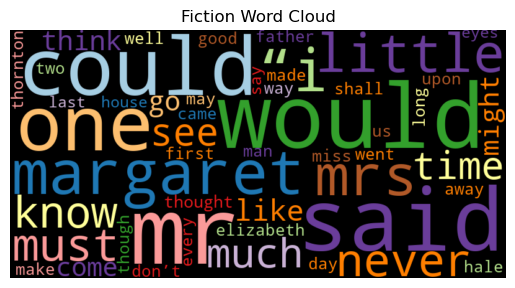

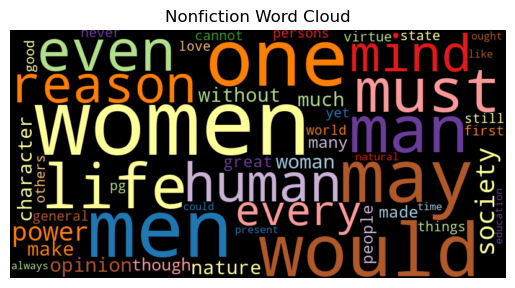

In [13]:
# Word clouds based on genre
# Function to count words
def count_words(df, column='Tokens', preprocess=None, min_freq=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    counter = Counter()
    df[column].map(update)

    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

# Count words for each genre
fiction_word_count = count_words(books[books['Genre'] == 'Fiction'], column='Tokens')
nonfiction_word_count = count_words(books[books['Genre'] == 'Nonfiction'], column='Tokens')

# Define the word cloud function
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400,
                   background_color="black", colormap="Paired",
                   max_font_size=150, max_words=max_words)
    
    # Convert data frame into dict
    if isinstance(word_freq, pd.Series):
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq
    
    # Filter stop words in frequency counter
    if stopwords is not None:
        counter = {token: freq for (token, freq) in counter.items() if token not in stopwords}
    
    wc.generate_from_frequencies(counter)
    
    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Generate word clouds for each genre
wordcloud(fiction_word_count['freq'], title="Fiction Word Cloud", max_words=50, stopwords=None)
wordcloud(nonfiction_word_count['freq'], title="Nonfiction Word Cloud", max_words=50, stopwords=None)

One of the most notable differences in the two word clouds of the genres is the inclusion and the size of the word "said" in fiction corporas. This is expected in that of fiction novels as the novel is likely heavy in dialect between characters in order to tell a story.

Similary, the nonfiction wordcloud sees words like "reason" and "opinion" that would suggest more factual, informational text. The wordclouds provide an overview of a clear difference in the sentiment of the two genres, which will hopefully transpire within the classification and topic modeling.

## Text Classification

This section separates the texts into sentences, splits the data into train and test sets with an 80/20 split, vectorizes the text using TF-IDF, and fits three different models: Logistic Regression as a baseline model, Naive Bayes, and a Support Vector Machine model. With text classification, we aim to identify a clear distinction between fiction and nonfiction books.

#### Fiction vs. Nonfiction

In [14]:
# Split text into sentences
books_expanded = books.assign(Text=books['Text'].apply(sent_tokenize)).explode('Text').reset_index(drop=True)

# Drop irrelevant columns
books_expanded = books_expanded.drop(columns=['Cleaned_Text', 'Tokens'])

# Remove rows where the Text column doesn't have at least 5 words
books_filtered = books_expanded[books_expanded['Text'].str.split().str.len() >= 5]

# Ensure books_filtered is a copy to avoid SettingWithCopyWarning
books_filtered = books_filtered.copy()

# Clean the text using a custom cleaning pipeline function
books_filtered['Cleaned_Text'] = books_filtered['Text'].apply(pipeline)

# Tokenize the cleaned text using a custom tokenization function
books_filtered['Tokens'] = books_filtered['Cleaned_Text'].apply(tokenize)

In [15]:
# Prepare data for modeling
# Prepare the features and labels
X = books_filtered['Cleaned_Text']  
y = books_filtered['Genre'] 

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorize the text data using TF-IDF in prep for models
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Validate split
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  20610
Size of Test Data  5153


##### Base Model - Logistic Regression

In [16]:
# Initialize and train a classification model (Logistic Regression in this case)
model = LogisticRegression(random_state=123)
model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_log = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_log))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

cr_log = classification_report(y_test, y_pred_log)
print("\nClassification Report:\n", cr_log)

Accuracy: 0.9305259072385018
Confusion Matrix:
 [[4024   52]
 [ 306  771]]

Classification Report:
               precision    recall  f1-score   support

     Fiction       0.93      0.99      0.96      4076
  Nonfiction       0.94      0.72      0.81      1077

    accuracy                           0.93      5153
   macro avg       0.93      0.85      0.88      5153
weighted avg       0.93      0.93      0.93      5153



The logisitc regression model is commonly beneficial with linear data. However, this model was trained due to its easily interpretable results, allowing the team to recognize any potential errors with the data early on before more complex modeling. The logisitc regression performs well with a 0.9305 accuracy.

##### Naive Bayes

In [17]:
# Train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_nb)) 

print("Confusion Matrix:", confusion_matrix(y_test, y_pred_nb))

cr_nb = classification_report(y_test, y_pred_nb)
print("\nClassification Report:\n", cr_nb)

Accuracy: 0.9435280419173298
Confusion Matrix: [[3993   83]
 [ 208  869]]

Classification Report:
               precision    recall  f1-score   support

     Fiction       0.95      0.98      0.96      4076
  Nonfiction       0.91      0.81      0.86      1077

    accuracy                           0.94      5153
   macro avg       0.93      0.89      0.91      5153
weighted avg       0.94      0.94      0.94      5153



A Naive Bayes notoriously classifies text data fairly well due to its unique ability to recognize the independence of every word while also being cost effective to deploy. This model is able to train quickly on vast amounts of data while enacting a strong predicting ability. This model performs better than the baseline with an accuracy of 0.9435.

##### Support Vector Machine

In [18]:
# Train SVM Model
svm_model = LinearSVC(random_state=123)
svm_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_svm)) 

print("Confusion Matrix:", confusion_matrix(y_test, y_pred_svm))

cr_svm = classification_report(y_test, y_pred_svm)
print("\nClassification Report:\n", cr_svm)

Accuracy: 0.9379002522802251
Confusion Matrix: [[3972  104]
 [ 216  861]]

Classification Report:
               precision    recall  f1-score   support

     Fiction       0.95      0.97      0.96      4076
  Nonfiction       0.89      0.80      0.84      1077

    accuracy                           0.94      5153
   macro avg       0.92      0.89      0.90      5153
weighted avg       0.94      0.94      0.94      5153



The support vector machine model, or SVM, is consistently accurate. However, it is slower to train with large data which will be an issue should it be deployed and more corpora are introduced. This last classification model performs better than the baseline, but not better than the Naive Bayes classification model.

#### Model Comparison

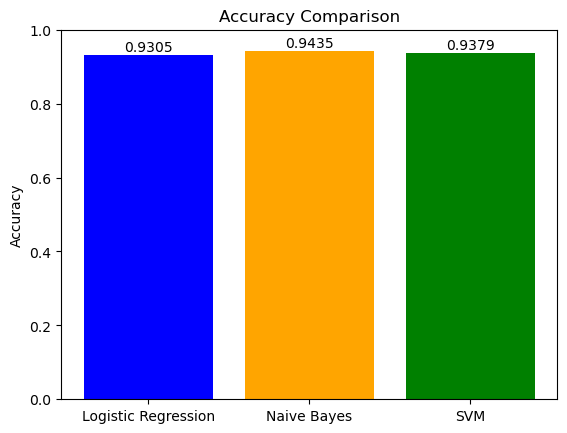

In [19]:
# Models
models = ['Logistic Regression', 'Naive Bayes', 'SVM']

# Accuracies
accuracies = [
    accuracy_score(y_test, y_pred_log),
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_svm)
]

# Plot bar chart
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.ylim(0, 1)

# Display accuracy scores
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)
plt.show()

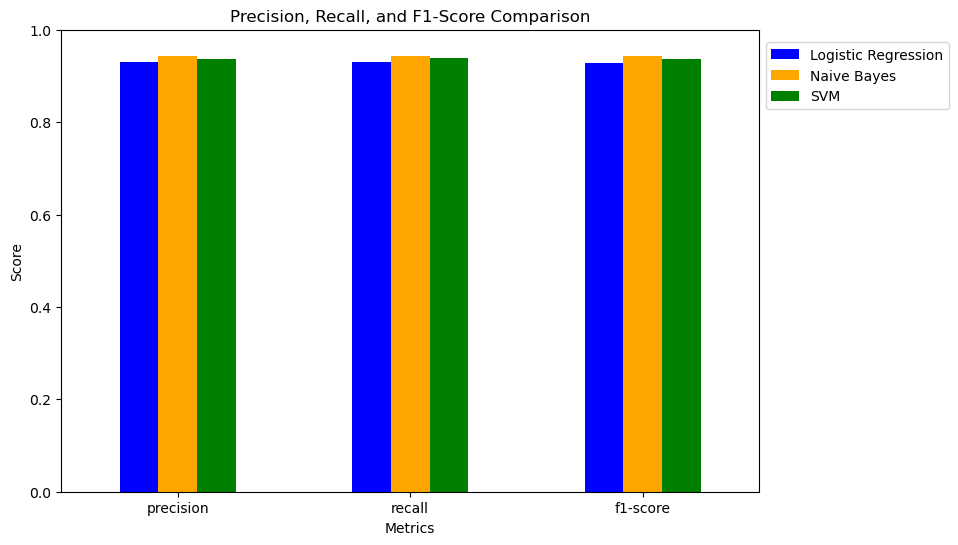

In [20]:
# Get classification report metrics as a dict
cr_log = classification_report(y_test, y_pred_log, output_dict=True)
cr_nb = classification_report(y_test, y_pred_nb, output_dict=True)
cr_svm = classification_report(y_test, y_pred_svm, output_dict=True)

# Extract precision, recall, and f1-score
metrics = ['precision', 'recall', 'f1-score']
log_metrics = [cr_log['weighted avg'][metric] for metric in metrics]
nb_metrics = [cr_nb['weighted avg'][metric] for metric in metrics]
svm_metrics = [cr_svm['weighted avg'][metric] for metric in metrics]

# Combine metrics into dataframe
df_metrics = pd.DataFrame({
    'Metrics': metrics,
    'Logistic Regression': log_metrics,
    'Naive Bayes': nb_metrics,
    'SVM': svm_metrics
})

# Plot grouped bar chart
df_metrics.set_index('Metrics').plot(kind='bar', figsize=(9, 6), color=['blue', 'orange', 'green'])
plt.title('Precision, Recall, and F1-Score Comparison')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.9), fontsize=10)
plt.show()

The three models used to classify the text have very similar performances. When looking at accuracy, the Naive Bayes model performs the best, although the difference between all the models is negligible. It is important to note that this could be an indication of potential overfitting. Similarly, the precision, recall, and f1-scores all fall within the same realm of performance, though the Naive Bayes model just slighty prevails as the best model. Overall, the successful performance indicates that the fiction and nonfiction genres have clear differences to be able to distinguish one from the other based on an individual sentence.

## Topic Modeling

We apply topic modeling techniques, including Non-Negative Matrix Factorization (NMF), Latent Semantic Analysis (LSA), and Latent Dirichlet Allocation (LDA), to uncover the primary themes within fiction and nonfiction. The models reveal distinct patterns, with fiction texts focusing on characters and dialogue, and nonfiction texts highlighting societal and philosophical concepts.

##### Non-Negative Factorization Model (NMF)

In [21]:
# Topic modeling for two predefined topics - Fiction and Nonfiction

# Call on previous vectorizer
tfidf_text_vectors = tfidf.fit_transform(books_filtered['Cleaned_Text'])

# Create Display topics Function
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

# NMF Topic Modeling
n_components = 2  # Fiction and Nonfiction
nmf_text_model = NMF(n_components=n_components, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

# Display the topics
display_topics(nmf_text_model, tfidf.get_feature_names_out())


Topic 00
 said (1.65)
 margaret (1.05)
 know (0.74)
 think (0.58)
 like (0.54)

Topic 01
 mr (7.45)
 thornton (3.25)
 mr thornton (2.76)
 hale (2.52)
 mr hale (1.92)


In [22]:
# Compare NMF assigned topic to original genre groups
books_filtered['NMF_Topic'] = np.argmax(W_text_matrix, axis=1)
pd.crosstab(books_filtered['NMF_Topic'], books_filtered['Genre'])

Genre,Fiction,Nonfiction
NMF_Topic,,
0,17573,5352
1,2807,31


Comparing the non-negative factorization assigned topics to the apriori groups shows that this topic modeling method does not align with the original grouping. The majority of the texts in both topics 0 and 1 come from the fiction genre. This also illustrates the class imbalance present in the data.

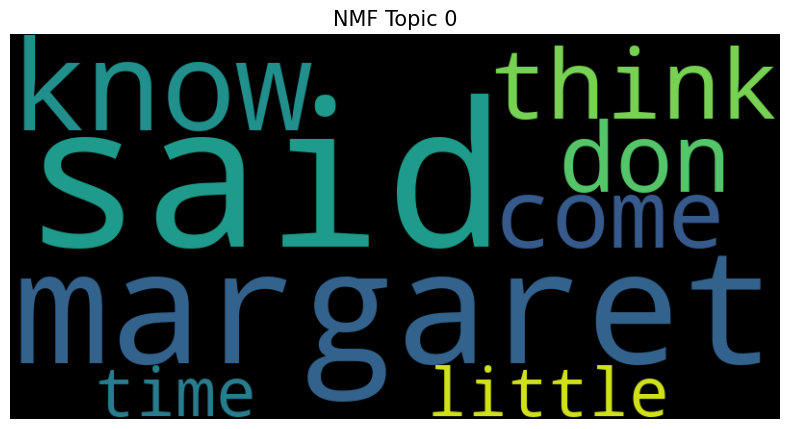

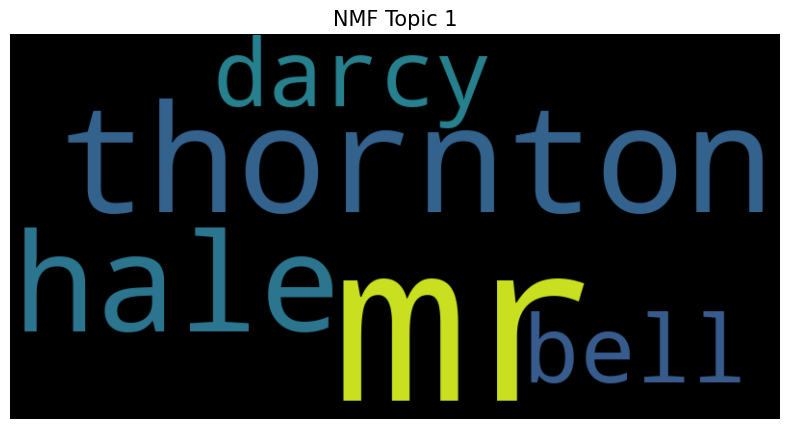

In [23]:
# Function to create a word cloud for a topic
def plot_word_cloud(topic_words, title):
    wordcloud = WordCloud(width=800, height=400).generate(" ".join(topic_words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=15)
    plt.show()

# NMF Topics
for topic, words in enumerate(nmf_text_model.components_):
    topic_words = [tfidf.get_feature_names_out()[i] for i in words.argsort()[:-11:-1]] # Get top 10 words for each topic
    plot_word_cloud(topic_words, title=f"NMF Topic {topic}")

Seeing as there are similarities between the two NMF word clouds for the top extracted features, our team infers that this topc model is not properly separating the predefined topics of the a priori groups.

##### Latent Semantic Analysis (LSA)

In [24]:
svd_text_model = TruncatedSVD(n_components = 2, random_state=123)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

# Map topics to genres
lsa_topic_to_category = defaultdict(list)
for idx, row in enumerate(W_svd_text_matrix):
    topic = np.where(row == np.amax(row))[0][0]  # Get the topic with the highest score
    category = books_filtered['Genre'].iloc[idx]  # Get the corresponding genre
    lsa_topic_to_category[topic].append(category)

# Display the number of documents for each topic and the most common categories
for topic, categories in lsa_topic_to_category.items():
    print(f"For topic {topic} we have {len(categories)} documents.")
    print(Counter(categories).most_common(5))
    print('\n') # add spacing for cleaner output

# Create Display topics Function
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

# Display the top words for each topic
display_topics(svd_text_model, tfidf.get_feature_names_out())

For topic 0 we have 24794 documents.
[('Fiction', 19417), ('Nonfiction', 5377)]


For topic 1 we have 969 documents.
[('Fiction', 963), ('Nonfiction', 6)]



Topic 00
 said (1.35)
 mr (1.21)
 margaret (0.89)
 know (0.57)
 thornton (0.54)

Topic 01
 mr (11.10)
 thornton (4.65)
 mr thornton (4.23)
 hale (3.21)
 mr hale (2.76)


In [25]:
# Compare LSA assigned topic to original genre groups
books_filtered['LSA_Topic'] = np.argmax(W_svd_text_matrix, axis=1)
pd.crosstab(books_filtered['LSA_Topic'], books_filtered['Genre'])

Genre,Fiction,Nonfiction
LSA_Topic,,
0,19417,5377
1,963,6


Similarly to the NMF assigned topics, the LSA assigned topics also do not aligned with the original grouping. The majority of the texts in both topics 0 and 1 come from the fiction genre, so neither topic is representative of the nonfiction genre.

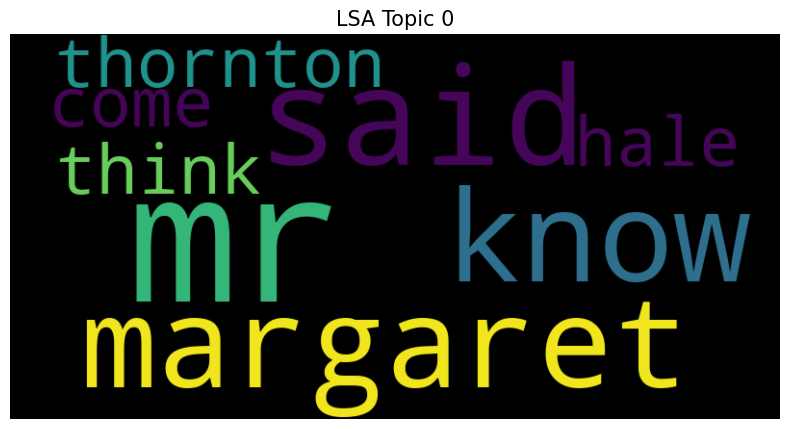

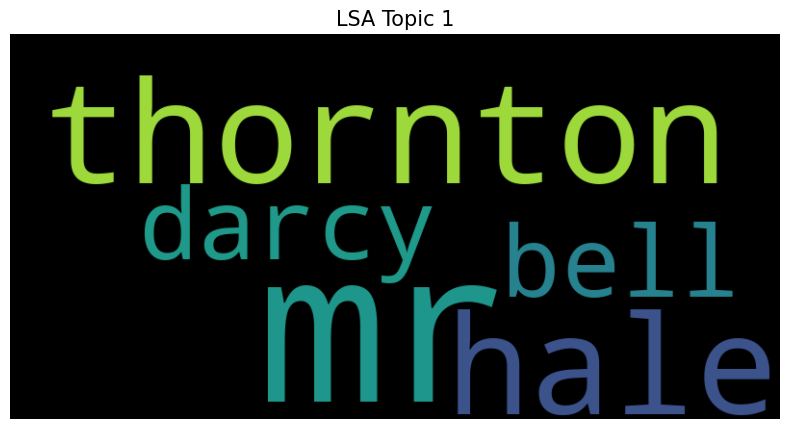

In [24]:
# LSA Topics
for topic, words in enumerate(svd_text_model.components_):
    topic_words = [tfidf.get_feature_names_out()[i] for i in words.argsort()[:-11:-1]]  # Get top 10 words for each topic
    plot_word_cloud(topic_words, title=f"LSA Topic {topic}")

Similar to the NMF modeling, the LSA word clouds seem to have similar thematic elements in both topics which is not inducive of the two genres of fiction and nonfiction writing.

##### Latent Dirichlet Allocation (LDA)

In [26]:
# Vectorizing text using CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
count_text_vectors = count_vectorizer.fit_transform(books_filtered['Cleaned_Text'])

# LDA Topic Modeling
lda_text_model = LatentDirichletAllocation(n_components=2, random_state=314)
W_text_matrix = lda_text_model.fit_transform(count_text_vectors)

# Create Display topics Function
def display_topics(model, features, no_top_words=5):
    for topic_idx, topic in enumerate(model.components_):
        total = topic.sum()  # Sum of the topic's word weights
        largest = topic.argsort()[::-1]  # Sort words by importance (highest to lowest)
        print(f"\nTopic {topic_idx:02d}")
        for i in range(no_top_words):
            word = features[largest[i]]
            weight = topic[largest[i]] * 100.0 / total  # Calculate relative importance
            print(f" {word} ({weight:.2f})")

# Display the top words for each topic
display_topics(lda_text_model, count_vectorizer.get_feature_names_out(), no_top_words=5)


Topic 00
 mr (1.28)
 said (1.15)
 margaret (0.83)
 mrs (0.63)
 know (0.52)

Topic 01
 women (0.75)
 men (0.69)
 man (0.58)
 life (0.48)
 mind (0.36)


In [27]:
# Compare LDA assigned topic to original genre groups
books_filtered['LDA_Topic'] = np.argmax(W_text_matrix, axis=1)
pd.crosstab(books_filtered['LDA_Topic'], books_filtered['Genre'])

Genre,Fiction,Nonfiction
LDA_Topic,,
0,16943,200
1,3437,5183


The LDA model aligns best with the apriori groups, by far. Topic 0 is about 99% fiction, and Topic 1 is a majority nonfiction. Looking at the top words for each topic, there is a clear distinction between fiction/topic 0 words and nonfiction/topic 1 words which is not the case for the NMF and LSA models.

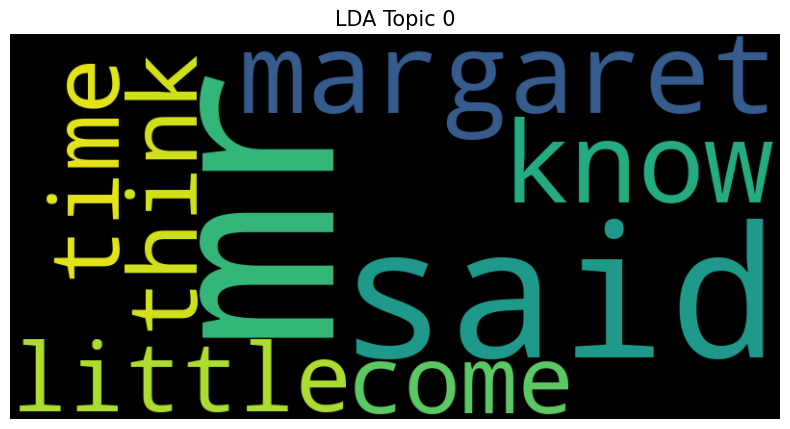

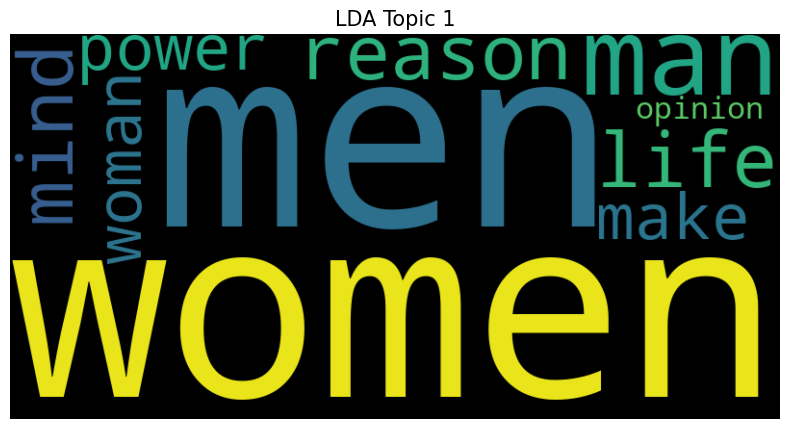

In [28]:
# Generate word clouds for LDA topics using CountVectorizer feature names
for topic_idx, topic in enumerate(lda_text_model.components_):
    topic_words = [count_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]  # Get top 10 words for each topic
    plot_word_cloud(topic_words, title=f"LDA Topic {topic_idx}")


The LDA model appears to best recognize which text belongs to a fiction or nonfiction genra. Ultimately, there is still crossover that the team would like to properly train the model to detect, but the classification compared to the a priori gorups is much stronger than that of the first two topic models.

In [29]:
# Prepare the corpus and dictionary
dictionary = corpora.Dictionary([doc.split() for doc in books_filtered['Cleaned_Text']])
corpus = [dictionary.doc2bow(doc.split()) for doc in books_filtered['Cleaned_Text']]


# Convert the sklearn LDA model to a Gensim compatible format
lda_gensim = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=2,
    random_state=42
)

# Visualize with pyLDAvis
lda_vis = gensimmod.prepare(lda_gensim, corpus, dictionary)
pyLDAvis.display(lda_vis)

The two topics presented above are clearly separated, suggesting that the model is finding unique verbiage to classify each text. However, it is important to note that many of the terms within each term frequency list are comparable to each other rather than unique findings. It begs the question of if the topic modeling is performing better than random guessing or not.

## Sentiment Analysis

Sentiment analysis is performed on each text to measure the overall tone, including positive, negative, and neutral sentiment. By comparing sentiment scores across genres, we observe that fiction tends to have a more varied emotional tone, while nonfiction is generally more neutral or informative. Box plots illustrate the sentiment distribution for both genres.

In [30]:
# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Split text into smaller chunks (like sentences) before applying sentiment analysis
def split_into_chunks(text, chunk_size=500):
    # Split the text into smaller chunks based on the chunk_size (number of characters)
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# Apply sentiment analysis to each chunk
def analyze_chunks(chunks):
    sentiment_scores = []
    for chunk in chunks:
        sentiment_scores.append(analyzer.polarity_scores(chunk))
    return sentiment_scores

# Process the text in chunks and then average the sentiment scores
def get_sentiment_for_large_text(text, chunk_size=500):
    chunks = split_into_chunks(text, chunk_size)
    sentiment_scores = analyze_chunks(chunks)
    
    # Average the sentiment scores across all chunks
    avg_sentiment = {
        'compound': sum(score['compound'] for score in sentiment_scores) / len(sentiment_scores),
        'pos': sum(score['pos'] for score in sentiment_scores) / len(sentiment_scores),
        'neg': sum(score['neg'] for score in sentiment_scores) / len(sentiment_scores),
        'neu': sum(score['neu'] for score in sentiment_scores) / len(sentiment_scores)
    }
    
    return avg_sentiment

# Apply this to your dataset
books['Sentiment'] = books['Cleaned_Text'].apply(get_sentiment_for_large_text)

# Display the first few rows to check the sentiment scores
print(books[['Title', 'Sentiment']].head())

                                       Title  \
0                        Pride and Prejudice   
1  The Awakening, and Selected Short Stories   
2                            North and South   
3                          Wuthering Heights   
4       A Vindication of the Rights of Woman   

                                           Sentiment  
0  {'compound': 0.6191476905311781, 'pos': 0.2341...  
1  {'compound': 0.49543906249999964, 'pos': 0.175...  
2  {'compound': 0.30668979079497893, 'pos': 0.177...  
3  {'compound': -0.04350863131935883, 'pos': 0.15...  
4  {'compound': 0.5965818749999992, 'pos': 0.2675...  


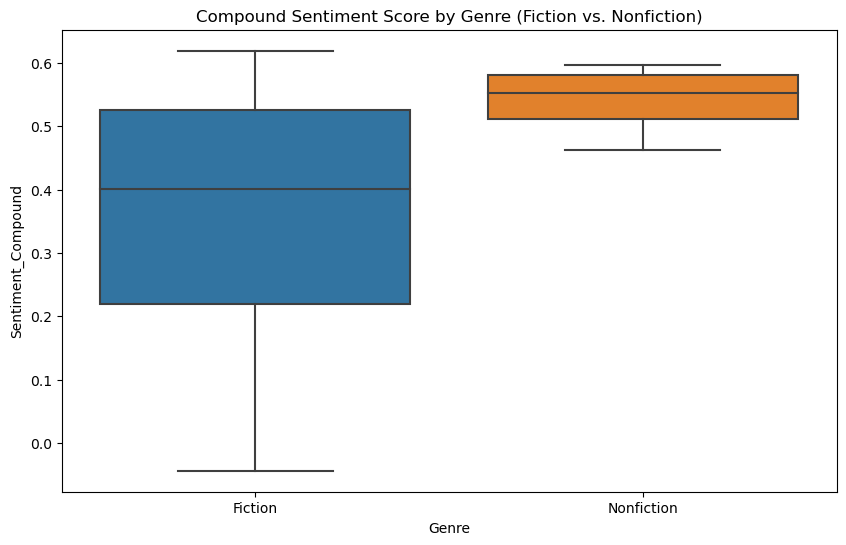

In [31]:
# Convert sentiment dictionaries into separate columns
books['Sentiment_Compound'] = books['Sentiment'].apply(lambda x: x['compound'])
books['Sentiment_Pos'] = books['Sentiment'].apply(lambda x: x['pos'])
books['Sentiment_Neg'] = books['Sentiment'].apply(lambda x: x['neg'])
books['Sentiment_Neu'] = books['Sentiment'].apply(lambda x: x['neu'])

# Plot sentiment by genre
plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='Sentiment_Compound', data=books)
plt.title('Compound Sentiment Score by Genre (Fiction vs. Nonfiction)')
plt.show()

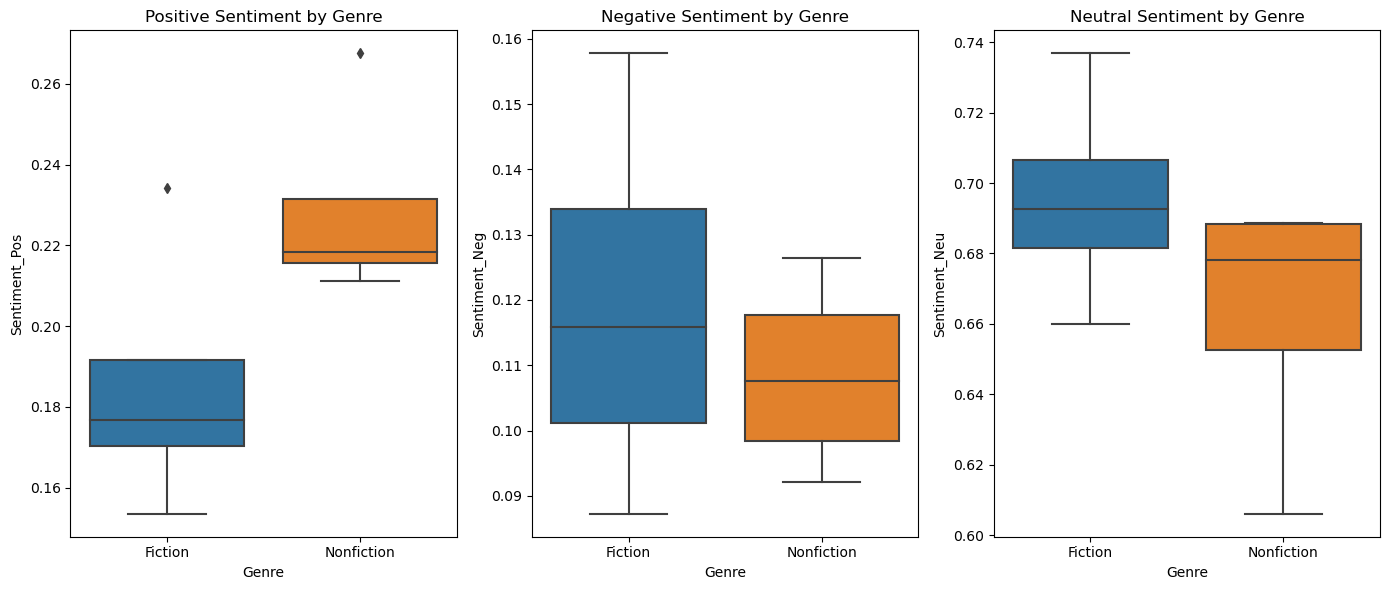

In [32]:
# Plot individual sentiment components
plt.figure(figsize=(14, 6))

# Positive sentiment
plt.subplot(1, 3, 1)
sns.boxplot(x='Genre', y='Sentiment_Pos', data=books)
plt.title('Positive Sentiment by Genre')

# Negative sentiment
plt.subplot(1, 3, 2)
sns.boxplot(x='Genre', y='Sentiment_Neg', data=books)
plt.title('Negative Sentiment by Genre')

# Neutral sentiment
plt.subplot(1, 3, 3)
sns.boxplot(x='Genre', y='Sentiment_Neu', data=books)
plt.title('Neutral Sentiment by Genre')

plt.tight_layout()
plt.show()

The compound sentiment score boxplot illustrates the much greater variability that fiction text has compared to nonfiction text. Intuitively, this makes sense since fictional books can convey a wider range of emotion than informational texts can. When analyzing positive sentiment by genre, the median positive sentiment score is lower for fiction. Oppositely, nonfiction has a lower median score for negative sentiments but continues to have a narrower range. Overall, nonfiction text has a narrower range of sentiment and typically expresses a more positive sentiment, whereas fiction text expresses a range of sentiment from very negative to very positive.